Ref: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [1]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [9]:
excludes_sites = ['Boskednan,']
excludes_features = ['other']

df = pd.read_csv(
    "data_clean.csv",
    index_col=[1,0],
    )
df.index = df.index.droplevel(0)  # read it in with areas but then get rid of them for now
df = df.fillna(0)
df = df.replace(['y', 'Y', '?'], [1, 1, 0.5])
df = df.astype(int)
# df = df.sort_index()
df.index = df.index.str.strip()
df = df[~df.index.isin(excludes_sites)]
df = df[df.columns[~df.columns.isin(excludes_features)]]
df

,standing stones/bouldrers,orthostats/boulders and bank,ditch and bank,bank,stones on or protrude from mound,"other, inc once below mound",regularly spaced,irregularly spaced,contiguoius,bank faced inside,...,paired stones outside,avenue row,other.2,part of complex,other.3,diam 1,diam 2,diam 3,diam 4,Unnamed: 50
Name,,,,,,,,,,,,,,,,,,,,,
Cerrig Pryfraid,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Brankam Hill 2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
Upper Auchnagorth,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Abercross,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Achanarass Hill,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lacra B,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Llacra D,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
Sdtanton Drew,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [10]:
def plot_dendrogram_from_df(df, method):
    X = df.values
    Z = linkage(X, method=method)

    c, coph_dists = cophenet(Z, pdist(X))

    plt.figure(figsize=(10, 25))
    plt.title(f'Hierarchical Clustering, {method} method\ncophenet: {c:.2f}')
    plt.xlabel('Distance')
    plt.ylabel('Site')
    dendrogram(
        Z,
        orientation='right',
        leaf_font_size=8.,  # font size for the x axis labels,
        labels=df.index,
        truncate_mode='level',
        p=4
    )
    plt.savefig(f"clustering - {method}.png")
    return Z

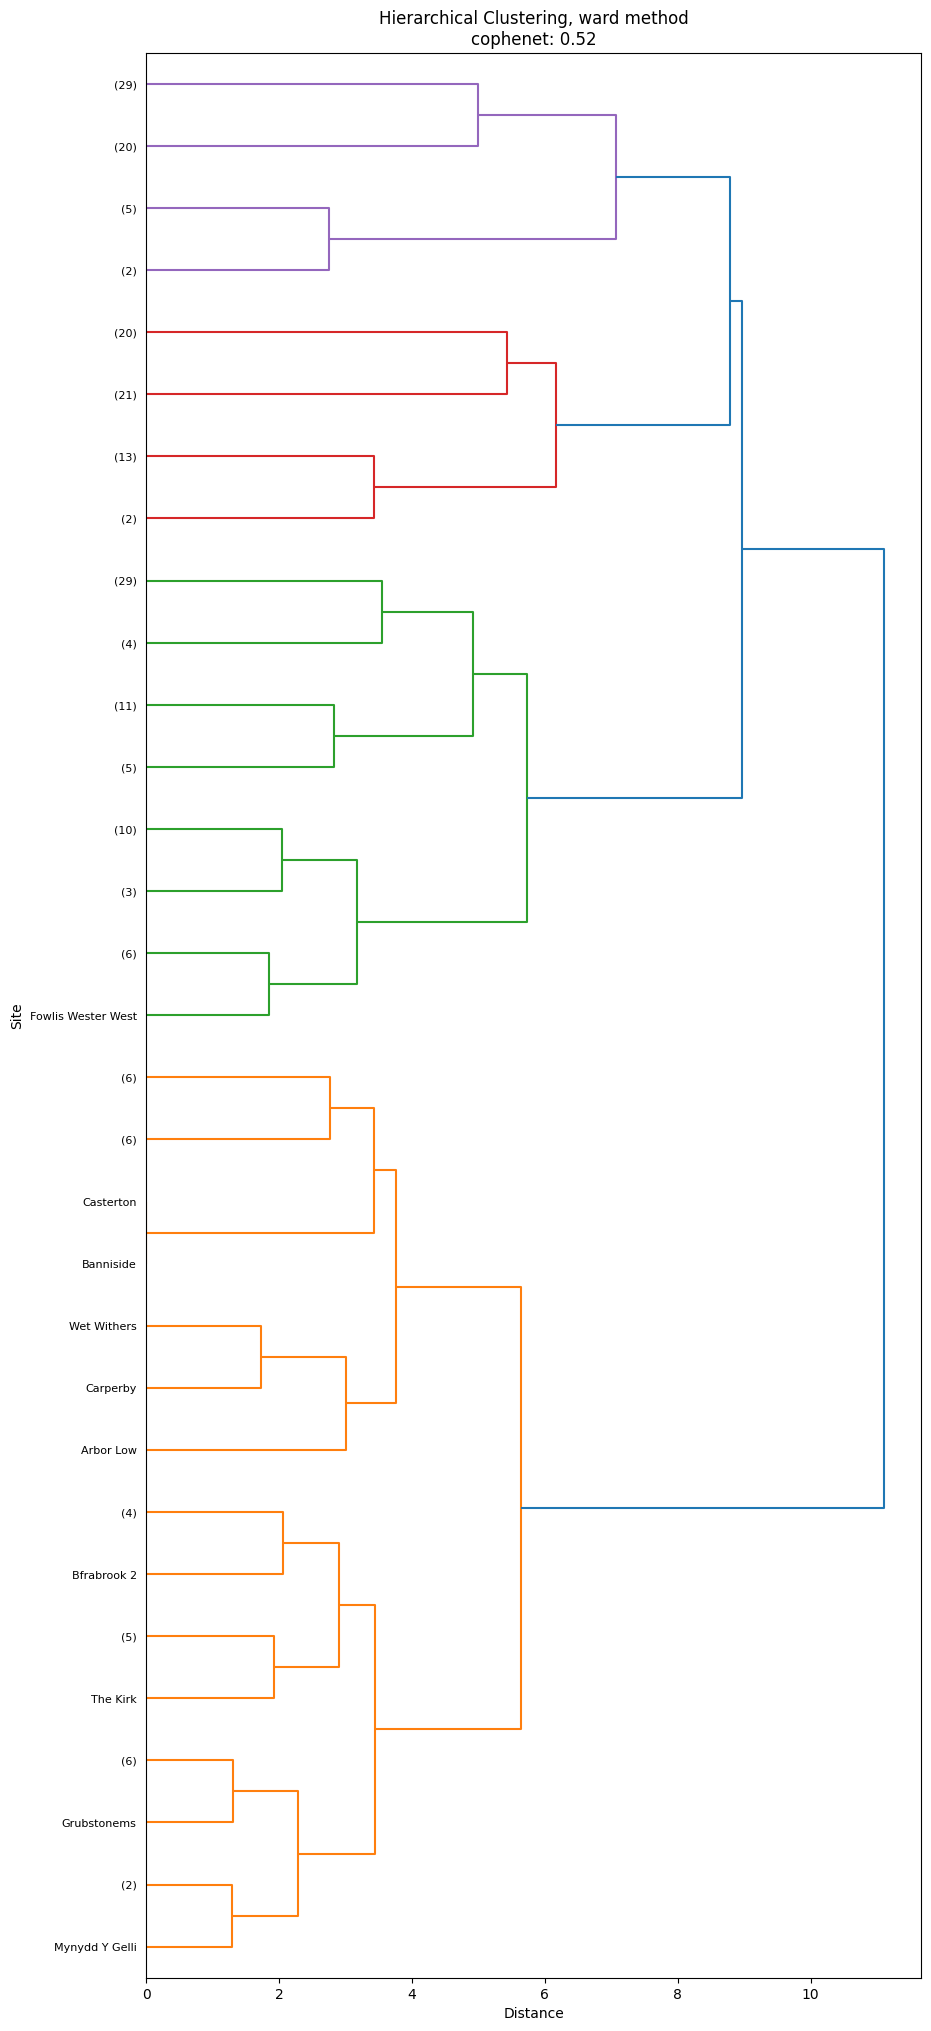

In [11]:
methods = [
    # 'single',
    # 'complete',
    # 'average',
    # 'weighted',
    # 'centroid',
    # 'median',
    'ward'
    ]

linkages = {method: plot_dendrogram_from_df(df, method) for method in methods}

In [14]:
n_clusters = 4
n_features = 10

L = linkages['ward']
df['clusters'] = fcluster(L, n_clusters, criterion='maxclust')
df.clusters = df.clusters.astype(str)  # for categorical plot labels

cluster_values = df.groupby('clusters').mean()

# compute difference metric
cluster_diffs = cluster_values.apply(lambda row: abs(cluster_values.iloc[cluster_values.index != row.name] - row).min(), axis=1)

# get top 10 columns by highest difference metric
col_order = cluster_diffs.max().T.sort_values(ascending=False).index
col_order = col_order[:n_features]

# reorder by value for cluster
# group_data = group_data[col_order]
# col_order = group_data.T.sort_values(by=['1'], ascending=False).index
cluster_diffs = cluster_diffs[col_order]
cluster_values = cluster_values[col_order]

fig = px.imshow(cluster_values, color_continuous_scale='greys')
fig.update_layout(title='Average value in cluster')
fig.show()
fig = px.imshow(cluster_diffs, color_continuous_scale='greys')
fig.update_layout(title='Difference metric')
fig.show()

In [18]:
for n in range(n_clusters):
    row_diffs = cluster_diffs.iloc[n]
    row_vals = cluster_values.iloc[n]
    print(f"Cluster {cluster_diffs.iloc[n]}")

Cluster standing stones/bouldrers       0.767857
orthostats/boulders and bank    0.727444
nothing in interior             0.054511
bank faced inside               0.447368
diam 1                          0.020976
diam 2                          0.025376
no perimeter focal point        0.044173
irregularly spaced              0.009398
stone circle insiode            0.052632
part of complex                 0.050752
Name: 1, dtype: float64
Cluster standing stones/bouldrers       0.078157
orthostats/boulders and bank    0.000000
nothing in interior             0.363872
bank faced inside               0.000000
diam 1                          0.020976
diam 2                          0.053571
no perimeter focal point        0.198322
irregularly spaced              0.011823
stone circle insiode            0.000000
part of complex                 0.142081
Name: 2, dtype: float64
Cluster standing stones/bouldrers       0.078157
orthostats/boulders and bank    0.035714
nothing in interior       

In [13]:
desc_df = cluster_values[cluster_diffs > 0.4]
desc_df = desc_df.dropna(how='all', axis=1)
desc_df = desc_df.round()
# cluster_descs = desc_df.apply(lambda row: )
desc_df

,standing stones/bouldrers,orthostats/boulders and bank,nothing in interior,bank faced inside
clusters,,,,
1,0.0,1.0,NaN,0.0
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,0.0,NaN
